In [1]:
# Imports and setup
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Parameters
images_per_class = 800
fixed_size = (500, 500)
train_path = "dataset/train"
h5_train_data = 'output/train_data.h5'
h5_train_labels = 'output/train_labels.h5'
bins = 8

In [3]:
# --- Feature extraction functions ---

def rgb_bgr(image):
    """Convert BGR image to RGB."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def bgr_hsv(rgb_img):
    """Convert RGB image to HSV."""
    return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)


In [4]:
def img_segmentation(rgb_img, hsv_img):
    """Segment healthy (green) and diseased (brown) regions in the image."""
    lower_green = np.array([25, 0, 20])
    upper_green = np.array([100, 255, 255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    
    lower_brown = np.array([10, 0, 10])
    upper_brown = np.array([30, 255, 255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

In [5]:
def fd_hu_moments(image):
    """Extract Hu Moments from grayscale image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.HuMoments(cv2.moments(gray)).flatten()

def fd_haralick(image):
    """Extract Haralick texture features."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return mahotas.features.haralick(gray).mean(axis=0)

In [6]:
def fd_histogram(image, mask=None):
    """Extract 3D color histogram from HSV image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], mask, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [7]:
# --- Load and process training data ---

train_labels = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
print("[INFO] Training classes:", train_labels)

global_features = []
labels = []

for class_label in train_labels:
    class_dir = os.path.join(train_path, class_label)
    print(f"[INFO] Processing class: {class_label}")
    
    for i in range(1, images_per_class + 1):
        img_path = os.path.join(class_dir, f"{i}.jpg")
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"[WARNING] Could not load image: {img_path}")
            continue
        
        image = cv2.resize(image, fixed_size)
        
        rgb_img = rgb_bgr(image)
        hsv_img = bgr_hsv(rgb_img)
        segmented_img = img_segmentation(rgb_img, hsv_img)
        
        # Extract features
        hu_moments = fd_hu_moments(segmented_img)
        #haralick = fd_haralick(segmented_img)  # optional, comment/uncomment as needed
        hist = fd_histogram(segmented_img)
        
        # Combine features (you can also add haralick if desired)
        features = np.hstack([hist, hu_moments])
        
        global_features.append(features)
        labels.append(class_label)

print("[INFO] Feature extraction complete")
print(f"[INFO] Features shape: {np.array(global_features).shape}")
print(f"[INFO] Labels shape: {np.array(labels).shape}")


[INFO] Training classes: ['diseased', 'healthy']
[INFO] Processing class: diseased
[INFO] Processing class: healthy
[INFO] Feature extraction complete
[INFO] Features shape: (1600, 519)
[INFO] Labels shape: (1600,)


In [8]:
# --- Encode labels and scale features ---

le = LabelEncoder()
target = le.fit_transform(labels)

scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[INFO] Labels encoded and features scaled")

[INFO] Labels encoded and features scaled


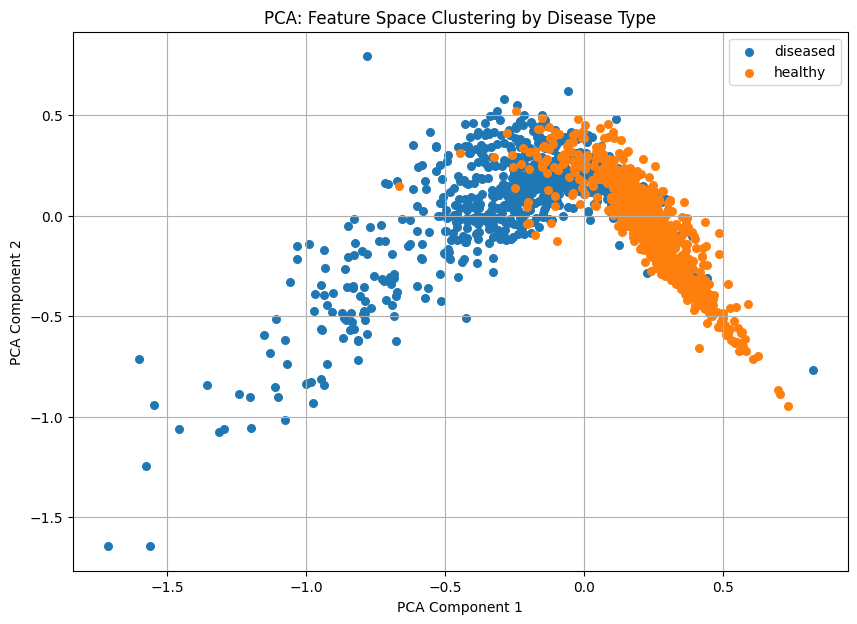

In [20]:
# --- Visualization with PCA ---

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rescaled_features)

plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(target)):
    plt.scatter(pca_components[target == label, 0], pca_components[target == label, 1], label=le.classes_[i], s=30)
plt.legend()
plt.title("PCA: Feature Space Clustering by Disease Type")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [ ]:
# --- Visualization with t-SNE ---

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_results = tsne.fit_transform(rescaled_features)

plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(target)):
    plt.scatter(tsne_results[target == label, 0], tsne_results[target == label, 1], label=le.classes_[i], s=30)
plt.legend()
plt.title("t-SNE: Feature Space Clustering by Disease Type")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

In [11]:
# --- Save features and labels in HDF5 ---

with h5py.File(h5_train_data, 'w') as h5f_data:
    h5f_data.create_dataset('dataset_1', data=rescaled_features)

with h5py.File(h5_train_labels, 'w') as h5f_label:
    h5f_label.create_dataset('dataset_1', data=target)

print("[INFO] Feature vectors and labels saved to HDF5")

[INFO] Feature vectors and labels saved to HDF5


In [12]:
# --- Model Training and Evaluation ---

num_trees = 100
test_size = 0.20
seed = 9
scoring = "accuracy"

In [13]:
# Load data back for training/testing (optional, can continue with variables above)
with h5py.File(h5_train_data, 'r') as h5f_data:
    features = np.array(h5f_data['dataset_1'])
with h5py.File(h5_train_labels, 'r') as h5f_label:
    labels = np.array(h5f_label['dataset_1'])

In [14]:
# Train-test split
(trainData, testData, trainLabels, testLabels) = train_test_split(features, labels, test_size=test_size, random_state=seed)

print(f"[INFO] Training data shape: {trainData.shape}")
print(f"[INFO] Test data shape: {testData.shape}")

[INFO] Training data shape: (1280, 519)
[INFO] Test data shape: (320, 519)


In [15]:
# Define classifiers
models = [
    ('LR', LogisticRegression(random_state=seed)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=seed)),
    ('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)),
    ('NB', GaussianNB()),
    ('SVM', SVC(random_state=seed))
]

results = []
names = []

print("[INFO] Starting 10-fold cross-validation for classifiers...")
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, trainData, trainLabels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} (+/- {cv_results.std():.4f})")


[INFO] Starting 10-fold cross-validation for classifiers...
LR: 0.9156 (+/- 0.0191)
LDA: 0.8953 (+/- 0.0172)
KNN: 0.9242 (+/- 0.0152)
CART: 0.9039 (+/- 0.0284)
RF: 0.9594 (+/- 0.0115)
NB: 0.8555 (+/- 0.0106)
SVM: 0.9227 (+/- 0.0118)


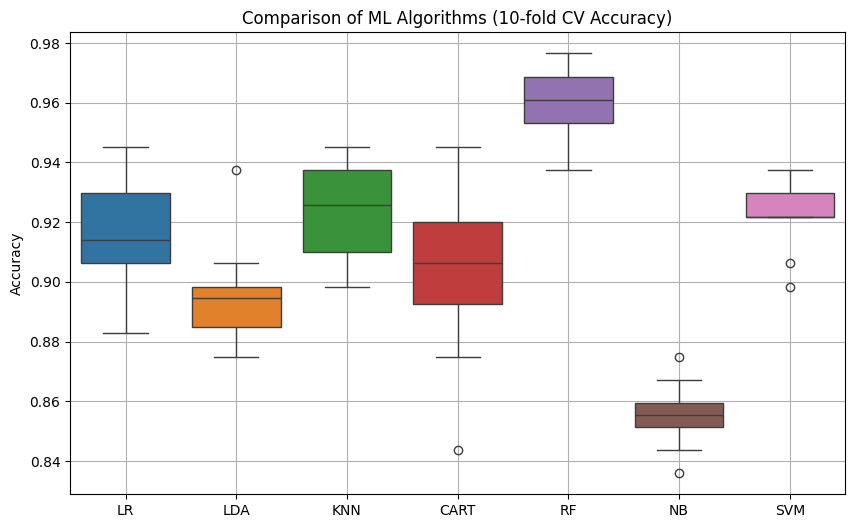

In [16]:
# Plot boxplot for comparison
plt.figure(figsize=(10, 6))
sns.boxplot(data=results)
plt.title("Comparison of ML Algorithms (10-fold CV Accuracy)")
plt.xticks(ticks=range(len(names)), labels=names)
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [17]:
# Train final model (Random Forest)
clf = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
clf.fit(trainData, trainLabels)

RandomForestClassifier(random_state=9)

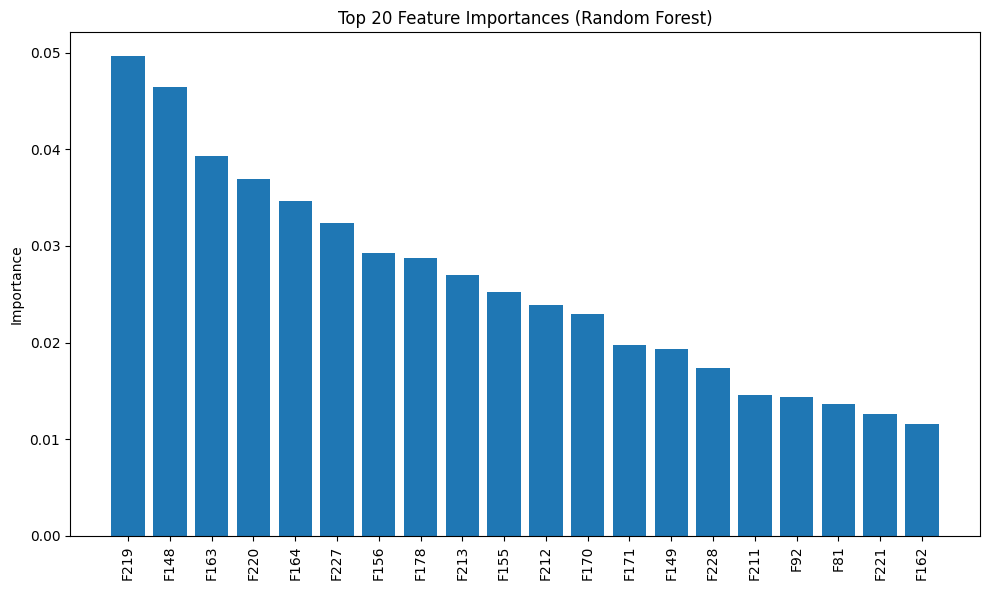

In [18]:
# Feature importance plot
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [f"F{i}" for i in indices], rotation=90)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


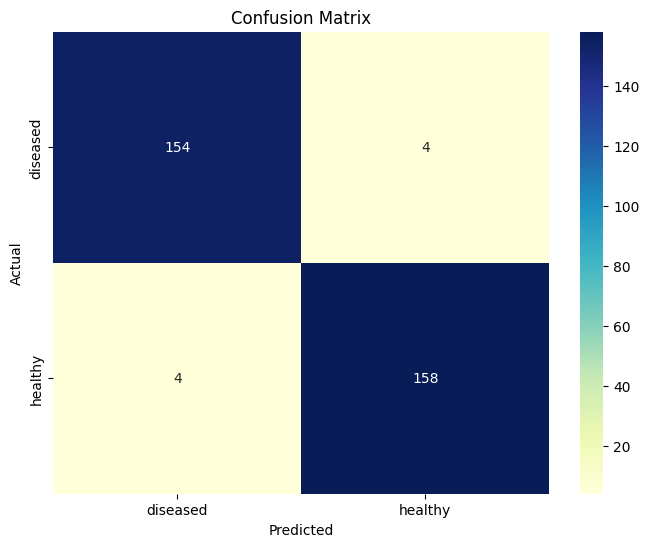

In [19]:
# Predict and evaluate on test set
y_pred = clf.predict(testData)

# Confusion matrix heatmap
cm = confusion_matrix(testLabels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
# Classification report
print(classification_report(testLabels, y_pred, target_names=le.classes_))

# Accuracy
acc = accuracy_score(testLabels, y_pred)
print(f"Test accuracy: {acc:.4f}")

              precision    recall  f1-score   support

    diseased       0.97      0.97      0.97       158
     healthy       0.98      0.98      0.98       162

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320

Test accuracy: 0.9750


In [25]:
# --- Save model, scaler and label encoder ---

joblib.dump(clf, 'output/rf_model.joblib')
joblib.dump(scaler, 'output/scaler.joblib')
joblib.dump(le, 'output/label_encoder.joblib')

print("[INFO] Model, scaler and label encoder saved successfully!")

[INFO] Model, scaler and label encoder saved successfully!


In [24]:
print(le.classes_)


['diseased' 'healthy']


In [ ]:
from collections import Counter
print(Counter(labels))
